In [2]:
import os
%pwd  # this tell us which path we are currently working , so based on the below output path we are working under the research file
os.chdir("C:\datascience End to End Projects\End-to-End-Heart-Disease-Application-")  #  but i would like to work with main ProjectML_with_MLFlow file , so for getting i step back in path inorder to enter the main project file i used this command os.chdir("../")
%pwd

'C:\\datascience End to End Projects\\End-to-End-Heart-Disease-Application-'

In [3]:
from dataclasses import dataclass
from pathlib import Path


@dataclass(frozen=True)
class ModelEvaluationConfig:
    root_dir: Path  # this root_dir,test_data_path,model_path,metric_file_name are the variables takes from the model_evaluation configuration code part of config.yaml file 
    test_data_path: Path
    model_path: Path
    #all_params: dict # these all params is available inside the params.yaml file which it reads all the parameters 
    metric_file_name: Path
    target_column: str # this target column takes from schema.yaml file 
    #mlflow_uri: str # this mlflow uri iagain write it down once again inside mlflow URI section

In [4]:
from PROJECTML.constants import *
from PROJECTML.utils.common import read_yaml, create_directories, save_json

In [5]:
# this template is same for every stage like data_ingestion, data_validation,data_transformation,model_trainer,model_evaluation

class ConfigurationManager:
    def __init__(
        self,
        config_filepath = CONFIG_FILE_PATH,
        params_filepath = PARAMS_FILE_PATH,
        schema_filepath = SCHEMA_FILE_PATH):

        self.config = read_yaml(config_filepath)
        self.params = read_yaml(params_filepath)
        self.schema = read_yaml(schema_filepath)

        create_directories([self.config.artifacts_root])

    # only this part of code get changes her actually iam defining a get_model_evaluation_config
    def get_model_evaluation_config(self) -> ModelEvaluationConfig:
        config = self.config.model_evaluation# here our model ElasticNet reading all params , Target_column of schema 
        #params = self.params.ElasticNet
        schema =  self.schema.TARGET_COLUMN

        create_directories([config.root_dir])

        model_evaluation_config = ModelEvaluationConfig(
            root_dir=config.root_dir,
            test_data_path=config.test_data_path,
            model_path = config.model_path,
            # all_params=params, # here iam saving all the parameters which i do experment while getting to know at which parameters our trained model which is ElastcNet is doing well
            metric_file_name = config.metric_file_name,
            target_column = schema.name,
            # mlflow_uri="https://dagshub.com/mahendra867/ProjectML_with_MLFlow.mlflow", # here i have setted the mlflow URI
           
        )

        return model_evaluation_config # so which ever the varaibles we initilized inside the entity those are all getting returned

In [10]:
import os
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score # here i have imported all the evaluation meterics for evaluating our model peformance
from urllib.parse import urlparse
# import mlflow
# import mlflow.sklearn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
import seaborn as sns
import pickle
from src.PROJECTML.utils.common import load_object1

In [17]:


# here i have defined one ModelEvaluation class in which i have defined the ModelEvaluationConfig
class ModelEvaluation:
    def __init__(self, config: ModelEvaluationConfig):
        self.config = config


    def model_evaluation(self):
        test_data=pd.read_csv(self.config.test_data_path)
        model=load_object1(self.config.model_path)
        test_x = test_data.drop([self.config.target_column], axis=1) # here iam dropping my targetcolumn in test_x
        test_y = test_data[[self.config.target_column]] # here iam keeping my target column
        # Confusion Matrix
        cm = confusion_matrix(test_y,model.predict(test_x))
        names = ['True Neg','False Pos','False Neg','True Pos']
        counts = [value for value in cm.flatten()]
        percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
        labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(names,counts,percentages)]
        labels = np.asarray(labels).reshape(2,2)
        sns.heatmap(cm,annot = labels,cmap = 'viridis',fmt ='')
    
    # Classification Report
        print(f"The classification report is :{classification_report(test_y,model.predict(test_x))}")



""" # here i have defiend the eval_metrics which it evaluates our model performance by calculating the rmse,mae,r2
    def eval_metrics(self,actual, pred):
        rmse = np.sqrt(mean_squared_error(actual, pred))
        mae = mean_absolute_error(actual, pred)
        r2 = r2_score(actual, pred)
        return rmse, mae, r2
    

# here i have defined one fucntion called log_into_mlflow which it will mlflow 
    def log_into_mlflow(self):

        test_data = pd.read_csv(self.config.test_data_path) # here iam loading the test dataset
        model = joblib.load(self.config.model_path) # here iam loading my trained model 

        test_x = test_data.drop([self.config.target_column], axis=1) # here iam dropping my targetcolumn in test_x
        test_y = test_data[[self.config.target_column]] # here iam keeping my target column


        mlflow.set_registry_uri(self.config.mlflow_uri) # here iam setting my tracking URI it is getting from configuration manager src because i want to everything inside a remote server 
        tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme


        with mlflow.start_run():

            predicted_qualities = model.predict(test_x) # here iam predicting my testing data

            (rmse, mae, r2) = self.eval_metrics(test_y, predicted_qualities) # here it is calculating my metrics of the predicted model
            
            # Saving metrics as local
            scores = {"rmse": rmse, "mae": mae, "r2": r2} # these scores are saving inside my artifacts of model_evaluation as a jason file
            save_json(path=Path(self.config.metric_file_name), data=scores)

            mlflow.log_params(self.config.all_params) # here iam logging with mlflow as log params,different log_mertics , and here iam giving all the parameters together which it will save inside ml flow

            mlflow.log_metric("rmse", rmse)
            mlflow.log_metric("r2", r2)
            mlflow.log_metric("mae", mae)

# here it will check whether we are doing inside the URI or in local directory , i already set the URL so it will save inside the URI 
            # Model registry does not work with file store
            if tracking_url_type_store != "file":

                # Register the model
                # There are other ways to use the Model Registry, which depends on the use case,
                # please refer to the doc for more information:
                # https://mlflow.org/docs/latest/model-registry.html#api-workflow
                mlflow.sklearn.log_model(model, "model", registered_model_name="ElasticnetModel") # here iam giving model ElasticnetModel
            else:
                mlflow.sklearn.log_model(model, "model") """

' # here i have defiend the eval_metrics which it evaluates our model performance by calculating the rmse,mae,r2\n    def eval_metrics(self,actual, pred):\n        rmse = np.sqrt(mean_squared_error(actual, pred))\n        mae = mean_absolute_error(actual, pred)\n        r2 = r2_score(actual, pred)\n        return rmse, mae, r2\n    \n\n# here i have defined one fucntion called log_into_mlflow which it will mlflow \n    def log_into_mlflow(self):\n\n        test_data = pd.read_csv(self.config.test_data_path) # here iam loading the test dataset\n        model = joblib.load(self.config.model_path) # here iam loading my trained model \n\n        test_x = test_data.drop([self.config.target_column], axis=1) # here iam dropping my targetcolumn in test_x\n        test_y = test_data[[self.config.target_column]] # here iam keeping my target column\n\n\n        mlflow.set_registry_uri(self.config.mlflow_uri) # here iam setting my tracking URI it is getting from configuration manager src because i

[2024-02-27 20:37:03,207: INFO: common: yaml file: config\config.yaml loaded successfully]
[2024-02-27 20:37:03,210: INFO: common: yaml file: params.yaml loaded successfully]
[2024-02-27 20:37:03,216: INFO: common: yaml file: schema.yaml loaded successfully]
[2024-02-27 20:37:03,219: INFO: common: created directory at: artifacts]
[2024-02-27 20:37:03,225: INFO: common: created directory at: artifacts/model_evaluation]


   Age Sex ChestPainType  Cholesterol  FastingBS  MaxHR ExerciseAngina  \
0   52   M           NAP            0          0    180              N   
1   43   M           ASY            0          0    145              Y   
2   71   M           ASY          221          0    115              Y   
3   37   M           ASY          315          0    158              N   
4   53   M           ASY            0          0    106              N   

   Oldpeak ST_Slope  HeartDisease  
0      3.0       Up             1  
1      2.0     Flat             1  
2      0.0     Flat             1  
3      0.0       Up             0  
4      0.0     Flat             1  
The classification report is :              precision    recall  f1-score   support

           0       0.88      0.84      0.86        89
           1       0.86      0.89      0.88        95

    accuracy                           0.87       184
   macro avg       0.87      0.87      0.87       184
weighted avg       0.87      0.87    

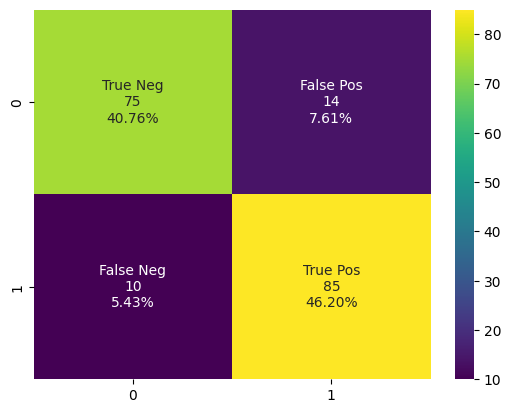

In [18]:
try:
    config = ConfigurationManager() # here i have initlized my ConfigurationManager()
    model_evaluation_config = config.get_model_evaluation_config() # her eiam getiing my get_model_evaluation_config()
    model_evaluation_config = ModelEvaluation(config=model_evaluation_config) # here iam passing this  model_evaluation_config to my ModelEvalaution
    model_evaluation_config.model_evaluation()
    # model_evaluation_config.log_into_mlflow() # here iam starting this log_into_mlflow()
except Exception as e: # if anything goes wrong it throws the exception
    raise e